## Семинар 1 "Полносвязные нейронные сети"

ФИО: Поспелова Алина Олеговна

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронной сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

Важным требованием к реализации является векторизация всех слоев: все операции должны быть сведены к матричным, не должно быть циклов. Это значительно уменьшает временные затраты.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Часть 1: Линейный слой


Приведем пример вычисления градиентов для линейного слоя: $y = xW^T$, $x \in \mathbb{R}^{K \times n}$, $y \in \mathbb{R}^{K \times n}$, $W \in \mathbb{R}^{m \times n}$, где $K$ — число объектов.

Рассмотрим $L$ как функцию от выходов нейронной сети: $L = L(y_{11}, y_{12}, \dots)$

$$y_i = (Wx)_i = \sum_j W_{i, j}x_j$$

$$\frac{\partial L}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial y_{kt}}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial \sum_z x_{kz}w_{zt}}{\partial x_{ij}}= \sum_{t} \frac{\partial L}{\partial y_{it}}\frac{\partial w_{jt}}{\partial x_{ij}}$$

$$\frac{\partial{L}}{\partial x} = \frac{\partial{L}}{\partial y}W$$

In [3]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        self.W = np.random.randn(input_size, output_size) * 0.01
        self.b = np.zeros(output_size)
        #### Create weights, initialize them with samples from N(0, 0.1).

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        self.Y = self.X.dot(self.W) + self.b
        return self.Y
        #### Apply layer to input

    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - learning_rate*dLdw
        '''
        self.W = self.W - learning_rate * self.dLdW
        self.b = self.b - learning_rate * self.dLdb

In [4]:
lin = Linear(10, 2)
X = np.ones((5, 10))
y = lin.forward(X)
dLdy = np.ones((5, 2))
lin.backward(dLdy).shape, lin.dLdW.shape, lin.dLdb.shape

((5, 10), (10, 2), (2,))

### Часть 2: Численный градиент

Релизуйте функцию проверки численного градиента. Для этого для каждой переменной, по которой считается градиент, надо вычислить численный градиент: $f'(x) \approx \frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$. Функция должна возвращать максимальное абсолютное отклонение аналитического градиента от численного. В качестве $\epsilon$ рекомендуется взять $10^{-6}$. При правильной реализации максимальное отличие будет иметь порядок $10^{-8}-10^{-6}$.

In [5]:
def check_gradient(func, X, gradient):
    '''
    Computes numerical gradient and compares it with analytcal.
    func: callable, function of which gradient we are interested. Example call: func(X)
    X: np.array of size (n x m)
    gradient: np.array of size (n x m)
    Returns: maximum absolute diviation between numerical gradient and analytical.
    '''
    numerical_gradient = np.zeros(X.shape)
    eps = 1e-5
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i, j] += eps
            y1 = func(X)
            X[i, j] -= 2 * eps
            y2 = func(X)
            X[i, j] += eps
            numerical_gradient[i, j] = (y1 - y2) / 2 / eps
    
    print (np.abs(numerical_gradient - gradient).max())

In [6]:
func = lambda x: (x ** 2).sum()

In [7]:
x = np.random.rand(10, 20)
gradient = 2 * x
check_gradient(func, x, 2 * x)

8.661975581247816e-10


Протестируйте линейный слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$ и $\frac{\partial L}{\partial w}$.

In [8]:
lin = Linear(10, 2)
X = np.ones((5, 10))
y = lin.forward(X)
func = lambda x: lin.forward(x).sum()
dLdy = np.ones((5, 2))
gradient = lin.backward(dLdy)
check_gradient(func, X, gradient)

1.8240062238383814e-12


In [9]:
lin = Linear(10, 2)
X = np.ones((5, 10))
y = lin.forward(X)
def func(W):
    W_old = lin.W
    lin.W = W
    y = lin.forward(X).sum()
    lin.W = W_old
    return y

dLdy = np.ones((5, 2))
W = lin.W
lin.backward(dLdy)
gradient = lin.dLdW
check_gradient(func, W, gradient)

3.326228181776969e-12


### Часть 3: Сигмоида

In [10]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 1. / (1 + np.exp(-X))
        return self.s
        #### Apply layer to input
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return self.s * (1 - self.s) * dLdy
    
    def step(self, learning_rate):
        pass

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [11]:
X = np.ones((5, 10))
s = Sigmoid()
def func(X):
    return s.forward(X).sum()

dLdy = np.ones((5, 10))
s.forward(X)
gradient = s.backward(dLdy)
check_gradient(func, X, gradient)

1.0723213983432345e-10


### Часть 4: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [12]:
class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        #### YOUR CODE HERE
        #### (Hint: No code is expected here, just joking)
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1
        return -(np.log(self.p)*self.y).sum(1).mean(0)
        #### Apply layer to input
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        return (self.p - self.y) / self.y.shape[0]

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [13]:
X = np.random.rand(15, 4)
y = np.random.randint(0, 4, 15)

In [14]:
loss = NLLLoss()
loss.forward(X, y)
func = lambda x: loss.forward(x, y)
check_gradient(func, X, loss.backward())

1.8663938450291795e-11


### Часть 5, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [15]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules
    
    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y
        #### Apply layers to input
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)
    
    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)

### Часть 6, обучение на простых данных

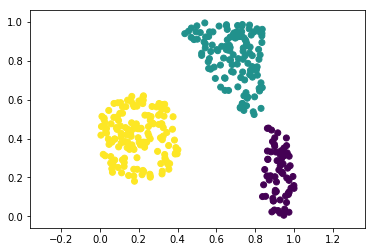

In [16]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.005). 
2. Нарисуйте график сходимости (величина NLL после каждого обновления).
3. Нарисуйте разделяющую поверхность
4. Попробуйте подобрать темп обучения. Как меняется сходимость?

In [17]:
arc = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 3)]
network = NeuralNetwork(arc)
loss_func = NLLLoss()

In [18]:
losses = []
for i in range(16000):
    prediction = network.forward(X)
    loss = loss_func.forward(prediction, y)
    losses.append(loss)
    dLdy = loss_func.backward()
    network.backward(dLdy)
    network.step(0.5) #Скорость обучения 0.005 слишком маленькая, не разделяет нужным образом.

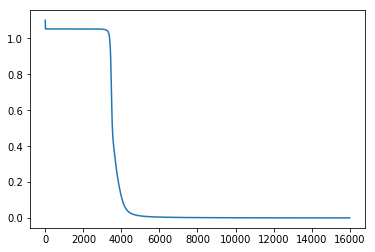

In [19]:
plt.plot(losses)

In [20]:
N = 50
x_grid = np.linspace(-0.2, 1.2, N)
y_grid = np.linspace(0, 1, N)

In [21]:
X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)

In [22]:
mesh = np.dstack((X_mesh, Y_mesh)).reshape(N * N, 2)
predictions = np.argmax(network.forward(mesh), 1)

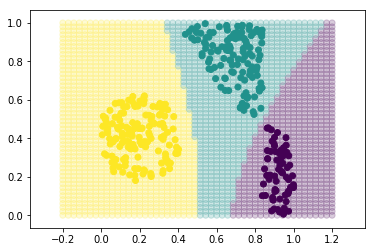

In [23]:
plt.scatter(mesh[:, 0], mesh[:, 1], c=predictions, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Отличная визуализация: http://playground.tensorflow.org/

## Домашнее задание:

* Подоберите темп обучения. Как меняется сходимость? Нарисуйте график оптимального значения функции потерь для различных значений learning_rate
* Решите поставленную выше задачу как задачу регрессии с MSE. Изменилась ли разделяющая поверхность?

In [263]:
class MSELoss:
    def __init__(self):
        '''
        Computes MSE loss
        '''
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, 1), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.X = X
        self.y = y.reshape(-1, 1)
        return (np.square(self.y - self.X)).mean()
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        return (2 * (self.X - self.y) / self.X.shape[0])

Тест слоя при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [264]:
X = np.random.rand(15, 1)
y = np.random.randint(0, 4, 15)

In [265]:
loss = MSELoss()
loss.forward(X, y)
func = lambda x: loss.forward(x, y)
dLdx = loss.backward()
check_gradient(func, X, dLdx)

1.9543366924779093e-11


Обучение на простых данных:

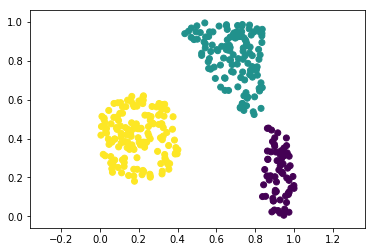

In [266]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Функция для построения графиков разных темпов обучения:

In [267]:
def plot_graphics(losses, learning_rates, y_coord, x_coord):
    fig, ax = plt.subplots(y_coord, x_coord, figsize=(x_coord * 5, y_coord * 5))
    for i in range(y_coord):
        for j in range(4):
            ax[i][j].plot(losses[i * x_coord + j], label="Minimum loss: {0}".format(round(losses[i * x_coord + j].min(), 2)))
            ax[i][j].legend()
            ax[i][j].set_title("Learning_rate: {0}".format(round(learning_rates[i * x_coord + j], 2)))
            ax[i][j].set_xlabel("Steps")
            ax[i][j].set_ylabel("MSELoss")

Сравниваю несколько темпов обучения:

In [268]:
#start - e^start - начальный темп обучения
#end - e^end - конечный темп обучения
#y_coord - количество графиков для разных темпов по ввертикали
#x_coord - количество графиков для разных темпов по горизонтали
#steps - количество шагов обучения
def cmp_rates(start, end, y_coord, x_coord, steps):
    min_loss, sought_rate, sought_steps, number = 1, 1, steps, y_coord * x_coord
    learning_rates =  np.logspace(start, end, number)
    losses = np.zeros((len(learning_rates), steps))
    for i, learning_rate in enumerate(learning_rates):
        arc = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 1)]
        network = NeuralNetwork(arc)
        loss_func = MSELoss()
        steps_min, pred_loss = steps, 1
        for j in range(steps):
            prediction = network.forward(X)
            loss = loss_func.forward(prediction, y)
            losses[i, j] = loss
            if pred_loss > loss:
                steps_min = j
            pred_loss = loss
            dLdy = loss_func.backward()
            network.backward(dLdy)
            network.step(learning_rate)
        if round(losses[i, steps_min - 1], 2) <= min_loss:
            min_loss = round(losses[i, steps_min - 1], 2)
            sought_rate = round(learning_rate, 2)
            sought_steps = steps_min
    print("Minimum MSELoss: ", min_loss)
    print("Sought learning rate: ", sought_rate)
    print("Number of needed steps: ", sought_steps)
    plot_graphics(losses, learning_rates, y_coord, x_coord)

Minimum MSELoss:  0.01
Sought learning rate:  0.79
Number of needed steps:  15999


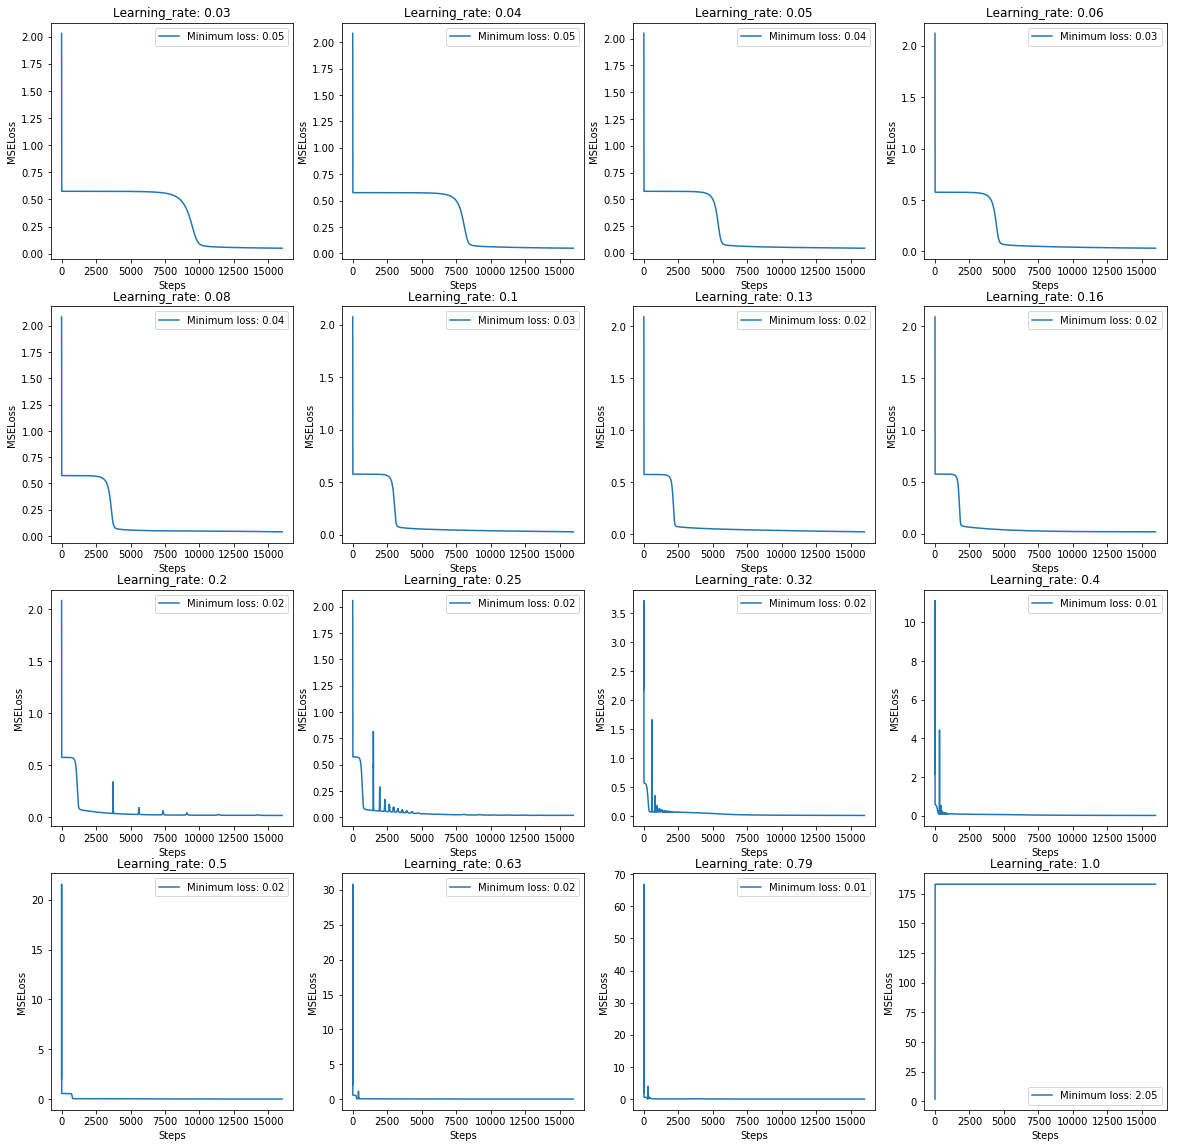

In [269]:
cmp_rates(-1.5, 0, 4, 4, 16000)

Получилось, что наилучший темп обучения примерно 0.79, на нём функция потерь MSE минимальная и равна 0.0 за 16000 шагов. Если брать количество шагов меньше, примерно, 1000, то там темп обучения 0.5 (можно подставить).
По графикам видно, что если темп обучения слишком маленький, то приходим в локальный экстремум,
если темп обучения слишком большой (>= 1), то уходим всё дальше от экстремумов.
Идеально получается при темпе нечто среднее, близкое к 1, но не достигающее её, когда идём прямо в глобальный экстремум.

In [270]:
arc = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 1)]
network = NeuralNetwork(arc)
loss_func = MSELoss()
for j in range(16000):
    prediction = network.forward(X)
    loss = loss_func.forward(prediction, y)
    dLdy = loss_func.backward()
    network.backward(dLdy)
    network.step(0.79)

In [271]:
N = 50
x_grid = np.linspace(-0.2, 1.2, N)
y_grid = np.linspace(0, 1, N)

In [272]:
X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)

In [273]:
mesh = np.dstack((X_mesh, Y_mesh)).reshape(N * N, 2)
predictions = np.squeeze(np.round(network.forward(mesh))).astype(int)

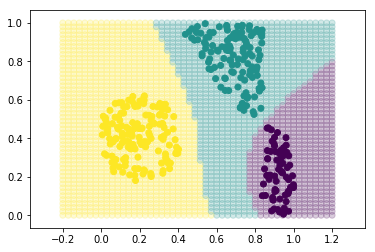

In [274]:
plt.scatter(mesh[:, 0], mesh[:, 1], c=predictions, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Разделяющая поверхность чуть-чуть изменилась. Области стали более плавные, выпуклые. Но в целом ненамного.